In [2]:
import pandas as pd
import re
import emoji
from langdetect import detect
import os

## Data Retrieving

rev 1 -> hrs  
rev2 -> hotelsone  
rev 3 -> galahotel

In [ ]:
df_hrs = pd.read_csv('./scrapped_reviews/trustpilot_reviews_1.csv') # old scraping
df_sone = pd.read_csv('./scrapped_reviews/trustpilot_reviews_2.csv') # old scraping
df_gala = pd.read_csv('./scrapped_reviews/trustpilot_reviews_3.csv') # old scraping
df_multi = pd.read_csv('./scrapped_reviews/reviews_multiple_urls.csv') #labelized data for training

In [4]:
df_multi

,source_url,title,body,date,score
0,https://www.trustpilot.com/review/www.hotels.com,Careful if you speak with some agents for any ...,"First, I needed a reply from the hotel side, b...","Date of experience: January 19, 2025",2
1,https://www.trustpilot.com/review/www.hotels.com,Will never use these again,Terrible service. Contacted them as I booked a...,"Date of experience: January 19, 2025",1
2,https://www.trustpilot.com/review/www.hotels.com,I wish I could leave a zero rating.,I wish I could leave a zero rating.Absolutely ...,"Date of experience: January 17, 2025",1
3,https://www.trustpilot.com/review/www.hotels.com,New loyalty programme scam,New loyalty programme from 10% (1 free night i...,"Date of experience: January 16, 2025",1
4,https://www.trustpilot.com/review/www.hotels.com,Been a Member for 20 years,"Been a Member for 20 years, I would NOT recomm...","Date of experience: January 17, 2025",1
...,...,...,...,...,...
19995,https://www.trustpilot.com/review/www.hostelwo...,Easy navigation and very thorough…,Easy navigation and very thorough presentation...,"Date of experience: May 30, 2022",5
19996,https://www.trustpilot.com/review/www.hostelwo...,Friendly and helpful staff,Friendly and helpful staff. Reasonably priced ...,"Date of experience: May 30, 2022",4
19997,https://www.trustpilot.com/review/www.hostelwo...,A long weekend in Paris,As mentioned the only small thing I could say ...,"Date of experience: May 30, 2022",5
19998,https://www.trustpilot.com/review/www.hostelwo...,Terrible customer service,Terrible customer service. My booking was canc...,"Date of experience: May 30, 2022",1


In [5]:
df_multi.isnull().sum()

source_url    0
title         0
body          0
date          0
score         0
dtype: int64

In [4]:
# 1 missing value in titlt col in df_gala
df_gala['title'] = df_gala['title'].fillna('No Title')
df_gala.isnull().sum()

title    0
body     0
date     0
dtype: int64

## Preprocessing & Traduction

In [14]:
#------Function for removing english stopwords------#

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stopwords(text, lang='english'):
    stop_words = set(stopwords.words(lang))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#------Function for translating to english------#

from deep_translator import GoogleTranslator

def translate_avis(avis, lang):
    return GoogleTranslator(source=lang, target='en').translate(avis)



In [17]:
import re
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("./frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

def correct_spelling_fast(text, lang='en'):

    words = text.split()

    corrected_words = []
    for word in words:
        correction = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(correction[0].term if correction else word)
    corrected_text = ' '.join(corrected_words)
    return corrected_text

#### HRS data

In [8]:
df_hrs['body'] = df_hrs['body'].str.lower()
df_hrs['body'] = df_hrs['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_hrs['body'] = df_hrs['body'].apply(lambda x: emoji.replace_emoji(x, replace=''))
df_hrs['language'] = df_hrs['body'].apply(detect)

In [9]:
df_hrs['language'].unique() #only english no need to translate

array(['en'], dtype=object)

In [10]:
df_hrs['body'] = df_hrs['body'].apply(remove_stopwords)

In [11]:
df_hrs['body'] = df_hrs['body'].apply(lambda x: correct_spelling_fast(x, lang='en'))

In [12]:
df_hrs.to_csv('./cleaned_rev/hrs_clean.csv',index=False)

#### Hotelsone data

In [13]:
df_sone['body'] = df_sone['body'].str.lower()
df_sone['body'] = df_sone['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_sone['body'] = df_sone['body'].apply(lambda x: emoji.replace_emoji(x, replace=''))
df_sone = df_sone[df_sone['body'].str.strip().astype(bool)] # remove reviews that only contains whitespaces
df_sone['language'] = df_sone['body'].apply(detect)

In [14]:
df_sone['language'].unique()

array(['en', 'da', 'fr', 'sk', 'fi', 'af', 'tl', 'so', 'it', 'cs', 'pl',
       'ro', 'es', 'cy', 'pt', 'no', 'nl', 'ca', 'lv', 'sl'], dtype=object)

In [15]:
print(df_sone['language'].value_counts()) #Many reviews in other languages, need to translate

language
en    3798
sk    1086
fr      32
af      12
ro      12
da      11
tl      10
it       8
ca       6
es       6
so       4
cy       2
pt       2
sl       2
cs       2
fi       2
no       1
nl       1
lv       1
pl       1
Name: count, dtype: int64


In [16]:
df_sone = df_sone[df_sone['language'] == 'en'] #Garder uniquement les review en anglais

In [17]:
df_sone['body'] = df_sone['body'].apply(remove_stopwords)

In [18]:
df_sone['body'] = df_sone['body'].apply(lambda x: correct_spelling_fast(x, lang='en'))

In [19]:
df_sone.to_csv('./cleaned_rev/HotelSone_clean.csv',index=False)

#### Gala Hotel Data

In [20]:
df_gala['body'] = df_gala['body'].str.lower()
df_gala['body'] = df_gala['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_gala['body'] = df_gala['body'].apply(lambda x: emoji.replace_emoji(x, replace=''))
df_gala = df_gala[df_gala['body'].str.strip().astype(bool)] # remove reviews that only contains whitespaces
df_gala['language'] = df_gala['body'].apply(detect)

In [21]:
df_gala['language'].unique()

array(['en', 'sk', 'sl', 'it', 'es', 'af', 'ca', 'fr', 'da', 'pl', 'so',
       'de', 'nl', 'ro', 'cy', 'hr', 'pt', 'no', 'tl'], dtype=object)

In [22]:
df_gala = df_gala[df_gala['language'] == 'en'] #Garder uniquement les review en anglais

In [23]:
df_gala['body'] = df_gala['body'].apply(remove_stopwords)

In [24]:
df_gala['body'] = df_gala['body'].apply(lambda x: correct_spelling_fast(x, lang='en'))

In [25]:
df_gala.to_csv('./cleaned_rev/GalaHotel_clean.csv',index=False)

#### Multi-review data

In [6]:
df_multi['body'] = df_multi['body'].str.lower()
df_multi['body'] = df_multi['body'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_multi['body'] = df_multi['body'].apply(lambda x: emoji.replace_emoji(x, replace=''))
df_multi = df_multi[df_multi['body'].str.strip().astype(bool)] # remove reviews that only contains whitespaces
df_multi['language'] = df_multi['body'].apply(detect)

C:\Users\thiba\AppData\Local\Temp\ipykernel_24552\3151614733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multi['language'] = df_multi['body'].apply(detect)


In [12]:
df_multi['language'].unique()

array(['en'], dtype=object)

In [10]:
print(df_multi['language'].value_counts()) #Many reviews in other languages, need to translate

language
en    18964
sk      879
fr       26
it       19
af       17
ro       14
ca       11
es       10
nl        9
da        9
hr        6
tl        6
no        6
cy        4
so        4
pt        3
sw        2
cs        2
et        2
sl        1
Name: count, dtype: int64


In [11]:
df_multi = df_multi[df_multi['language'] == 'en'] #Garder uniquement les review en anglais

In [15]:
df_multi['body'] = df_multi['body'].apply(remove_stopwords)

In [18]:
df_multi['body'] = df_multi['body'].apply(lambda x: correct_spelling_fast(x, lang='en'))

In [19]:
df_multi.to_csv('./cleaned_rev/Multi_rev_clean.csv',index=False)

#### Concatenation for models

In [26]:
df_combined = pd.concat([df_hrs, df_sone, df_gala], ignore_index=True)
df_combined.to_csv('./cleaned_rev/concat_rev.csv')

## Model Setup & Training

#### Topic Classification (LDA)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

X_tfidf = vectorizer.fit_transform(df_combined['body'])


In [28]:
from sklearn.decomposition import LatentDirichletAllocation


n_topics = 7
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

lda.fit(X_tfidf)

# Extract the topics (words associated with each topic)
feature_names = vectorizer.get_feature_names_out()
n_top_words = 20  # Number of words to display per topic

# Print topics
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic 0:
friendly, good, staff, clean, location, great, room, spacious, excellent, live, helpful, nice, stay, service, offers, hotel, site, comfortable, best, sure
Topic 1:
valid, easily, card, book, using, credit, hotel, hrs, rates, issues, reliable, search, point, willing, able, rating, shows, course, consistently, end
Topic 2:
hotel, room, booking, best, prices, hrs, breakfast, avoid, process, easy, night, use, good, old, bad, included, nice, staff, desk, clean
Topic 3:
really, good, business, site, pricing, rooms, wants, need, platform, limited, past, recently, people, significant, perfect, number, wonderful, experience, book, options
Topic 4:
easy, simple, fast, rates, hotels, use, booking, process, choice, convenient, selection, bookings, particular, germany, interesting, la, reward, wide, cities, small
Topic 5:
improve, information, site, hotels, user, hrs, satisfied, quality, high, friendliness, bit, web, worth, automatically, regards, italian, blast, kind, applied, page
Topic 

Results are not satisfying enough, We will try using zero-shot model

In [29]:
# Get topic distribution for each review
topic_distribution = lda.transform(X_tfidf)

# Assign the review to the topic with the highest probability
df_combined['assigned_topic'] = topic_distribution.argmax(axis=1)

In [30]:
df_combined['assigned_topic']

0        5
1        4
2        3
3        3
4        0
        ..
13343    3
13344    0
13345    0
13346    6
13347    0
Name: assigned_topic, Length: 13348, dtype: int64

#### Topic classification (Zero-shot Model)

In [17]:
from transformers import pipeline
import json
import torch
from tqdm import tqdm
from datasets import Dataset

labels = ['service', 'cleanliness', 'overall', 'value', 'location', 'sleep_quality', 'rooms']
classifier = pipeline("zero-shot-classification", model="knowledgator/comprehend_it-base", device=0)
result = []
dataset = Dataset.from_pandas(df_combined[['body']])
for review in tqdm(dataset['body'], total=len(dataset['body']), desc="Classifying Reviews", unit="review"):
    classification = classifier(review, candidate_labels=labels)
    top_label = classification['labels'][0]
    result.append(top_label)
df_combined['classif_result'] = result

# Check the updated DataFrame
print(df_combined[['body', 'classif_result']].head())


NameError: name 'df_combined' is not defined

In [35]:
df_combined.to_csv('./nlp_results/rev_topic.csv',index=False)

#### Sentiment Analysis (Zero-shot Model)

In [36]:
from transformers import pipeline
import json
import torch
from tqdm import tqdm
from datasets import Dataset

labels_st = ['Positive', 'Negative', 'Neutral']
classifier_st = pipeline("zero-shot-classification", model="FacebookAI/roberta-base", device=0)
result_st = []
for review in tqdm(dataset['body'], total=len(dataset['body']), desc="Classifying Reviews", unit="review"):
    classification = classifier(review, candidate_labels=labels_st)
    top_label = classification['labels'][0]
    result_st.append(top_label)
df_combined['sentiment_result'] = result_st

print(df_combined[['body', 'sentiment_result']].head())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Classifying Reviews: 100%|██████████| 13348/13348 [11:12<00:00, 19.86review/s]

                                                body sentiment_result
0  much known like otis really worth book rooms w...         Positive
1  easy booking process wide selection hotels eve...         Positive
2  really good site need book several rooms wants...         Positive
3  great hotel comfortable perfect short staysthe...         Positive
4   friendly staff good location clean spacious room         Positive


In [37]:
df_combined.to_csv('./nlp_results/rev_topic_sentiment.csv',index=False)

#### Rating Prediction (Supervised Learning)

In [ ]:
import os
import torch
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.cuda.empty_cache()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

In [4]:
df = pd.read_csv('./cleaned_rev/Multi_rev_clean.csv', delimiter=',')
df = df[['score', 'body']]
df['score'] = df['score'].astype(int) - 1 # -1 sinon erreur avec cuda

x_train, x_test, y_train, y_test = train_test_split(df['body'], df['score'], test_size=0.2)

train_data = Dataset.from_dict({'text': x_train.tolist(), 'label': y_train.tolist()})
test_data = Dataset.from_dict({'text': x_test.tolist(), 'label': y_test.tolist()})


In [5]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/15171 [00:00<?, ? examples/s]

Map:   0%|          | 0/3793 [00:00<?, ? examples/s]

In [6]:
from sklearn.metrics import mean_squared_error

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    mse = mean_squared_error(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mse': mse,
    }


In [8]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)


In [9]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/11379 [00:00<?, ?it/s]

{'loss': 1.6034, 'grad_norm': 3.569124937057495, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 1.5808, 'grad_norm': 4.3157548904418945, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'loss': 1.5276, 'grad_norm': 5.593752384185791, 'learning_rate': 3e-06, 'epoch': 0.01}
{'loss': 1.4493, 'grad_norm': 3.662710666656494, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01}
{'loss': 1.3849, 'grad_norm': 4.865753650665283, 'learning_rate': 5e-06, 'epoch': 0.01}
{'loss': 1.2553, 'grad_norm': 7.207294464111328, 'learning_rate': 6e-06, 'epoch': 0.02}
{'loss': 1.0717, 'grad_norm': 4.820284843444824, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.02}
{'loss': 0.8739, 'grad_norm': 4.52303409576416, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.02}
{'loss': 0.7827, 'grad_norm': 4.329233646392822, 'learning_rate': 9e-06, 'epoch': 0.02}
{'loss': 0.7628, 'grad_norm': 4.559178829193115, 'learning_rate': 1e-05, 'epoch': 0.03}
{'loss': 0.9749, 'grad_norm': 4.0043869

  0%|          | 0/949 [00:00<?, ?it/s]

c:\Users\thiba\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.4182676076889038, 'eval_accuracy': 0.9003427366200897, 'eval_precision': 0.853688307591727, 'eval_recall': 0.9003427366200897, 'eval_f1': 0.8753547219630642, 'eval_mse': 0.43026627998945427, 'eval_runtime': 10.2304, 'eval_samples_per_second': 370.757, 'eval_steps_per_second': 92.763, 'epoch': 1.0}
{'loss': 0.525, 'grad_norm': 7.080948829650879, 'learning_rate': 3.483316481294237e-05, 'epoch': 1.0}
{'loss': 0.542, 'grad_norm': 0.39599791169166565, 'learning_rate': 3.478720470631492e-05, 'epoch': 1.0}
{'loss': 0.4911, 'grad_norm': 7.057379245758057, 'learning_rate': 3.4741244599687474e-05, 'epoch': 1.01}
{'loss': 0.4014, 'grad_norm': 7.425635814666748, 'learning_rate': 3.469528449306003e-05, 'epoch': 1.01}
{'loss': 0.4755, 'grad_norm': 0.3161143660545349, 'learning_rate': 3.464932438643258e-05, 'epoch': 1.01}
{'loss': 0.3532, 'grad_norm': 0.2966099977493286, 'learning_rate': 3.4603364279805126e-05, 'epoch': 1.02}
{'loss': 0.2807, 'grad_norm': 1.743094563484192, 'learning_

  0%|          | 0/949 [00:00<?, ?it/s]

{'eval_loss': 0.4170862138271332, 'eval_accuracy': 0.9006063801740047, 'eval_precision': 0.8619565821826224, 'eval_recall': 0.9006063801740047, 'eval_f1': 0.8780502681070036, 'eval_mse': 0.3625098866332718, 'eval_runtime': 10.2022, 'eval_samples_per_second': 371.783, 'eval_steps_per_second': 93.019, 'epoch': 2.0}
{'loss': 0.655, 'grad_norm': 10.513357162475586, 'learning_rate': 1.741428440113981e-05, 'epoch': 2.0}
{'loss': 0.254, 'grad_norm': 0.14602038264274597, 'learning_rate': 1.7368324294512363e-05, 'epoch': 2.0}
{'loss': 0.3345, 'grad_norm': 0.9270245432853699, 'learning_rate': 1.732236418788492e-05, 'epoch': 2.01}
{'loss': 0.0897, 'grad_norm': 0.1307155042886734, 'learning_rate': 1.727640408125747e-05, 'epoch': 2.01}
{'loss': 0.3789, 'grad_norm': 0.18392200767993927, 'learning_rate': 1.7230443974630022e-05, 'epoch': 2.01}
{'loss': 0.4893, 'grad_norm': 8.045831680297852, 'learning_rate': 1.7184483868002574e-05, 'epoch': 2.01}
{'loss': 0.1383, 'grad_norm': 0.19653569161891937, 'lea

  0%|          | 0/949 [00:00<?, ?it/s]

{'eval_loss': 0.45807451009750366, 'eval_accuracy': 0.9016609543896652, 'eval_precision': 0.8817701488152675, 'eval_recall': 0.9016609543896652, 'eval_f1': 0.8893514607778616, 'eval_mse': 0.31795412602161877, 'eval_runtime': 10.3668, 'eval_samples_per_second': 365.881, 'eval_steps_per_second': 91.543, 'epoch': 3.0}
{'train_runtime': 771.6544, 'train_samples_per_second': 58.981, 'train_steps_per_second': 14.746, 'train_loss': 0.4215389111126173, 'epoch': 3.0}


TrainOutput(global_step=11379, training_loss=0.4215389111126173, metrics={'train_runtime': 771.6544, 'train_samples_per_second': 58.981, 'train_steps_per_second': 14.746, 'total_flos': 1507327817598720.0, 'train_loss': 0.4215389111126173, 'epoch': 3.0})

In [10]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Metrics:", eval_results)


  0%|          | 0/949 [00:00<?, ?it/s]

Evaluation Metrics: {'eval_loss': 0.4170862138271332, 'eval_accuracy': 0.9006063801740047, 'eval_precision': 0.8619565821826224, 'eval_recall': 0.9006063801740047, 'eval_f1': 0.8780502681070036, 'eval_mse': 0.3625098866332718, 'eval_runtime': 10.7474, 'eval_samples_per_second': 352.924, 'eval_steps_per_second': 88.301, 'epoch': 3.0}


In [11]:
# Save the trained model and tokenizer
model.save_pretrained("model_saved")
tokenizer.save_pretrained("model_saved")


('model_saved\\tokenizer_config.json',
 'model_saved\\special_tokens_map.json',
 'model_saved\\vocab.txt',
 'model_saved\\added_tokens.json')

## Labelizing the concat-rev with predicted ratings

In [5]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import pandas as pd

model = DistilBertForSequenceClassification.from_pretrained("./model_saved")
tokenizer = DistilBertTokenizer.from_pretrained("./model_saved")
model.to('cuda')
model.eval()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [6]:
torch.cuda.empty_cache()

In [7]:
def predict_score(text):
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item() 

    return predicted_class


In [18]:
unlabelled_data = pd.read_csv("./nlp_results/rev_topic_sentiment.csv")
print(unlabelled_data.head())
text_data = unlabelled_data['body'].astype(str)
predicted_scores = []
for text in text_data:
    score = predict_score(text)
    predicted_scores.append(score)

unlabelled_data['predicted_score'] = predicted_scores
unlabelled_data.to_csv("./nlp_results/rev_topic_sentiment_rating.csv", index=False)


                                      title  \
0                           A great finding   
1                              Good choice!   
2  Its a really good site when you need to…   
3                    This was a great hotel   
4                            Friendly staff   

                                                body  \
0  much known like otis really worth book rooms w...   
1  easy booking process wide selection hotels eve...   
2  really good site need book several rooms wants...   
3  great hotel comfortable perfect short staysthe...   
4   friendly staff good location clean spacious room   

                                    date language  assigned_topic  \
0  Date of experience: December 17, 2024       en               5   
1  Date of experience: December 16, 2024       en               4   
2  Date of experience: December 16, 2024       en               3   
3  Date of experience: November 18, 2024       en               3   
4  Date of experience: December 11,

## Visualisation after processing via the models

In [19]:
import pandas as pd

data = pd.read_csv("./nlp_results/rev_topic_sentiment_rating.csv")
data.head()


,title,body,date,language,assigned_topic,classif_result,sentiment_result,predicted_score
0,A great finding,much known like otis really worth book rooms w...,"Date of experience: December 17, 2024",en,5,value,Positive,4
1,Good choice!,easy booking process wide selection hotels eve...,"Date of experience: December 16, 2024",en,4,rooms,Positive,4
2,Its a really good site when you need to…,really good site need book several rooms wants...,"Date of experience: December 16, 2024",en,3,rooms,Positive,4
3,This was a great hotel,great hotel comfortable perfect short staysthe...,"Date of experience: November 18, 2024",en,3,rooms,Positive,4
4,Friendly staff,friendly staff good location clean spacious room,"Date of experience: December 11, 2024",en,0,cleanliness,Positive,4


In [21]:
grouped_data = data.groupby("sentiment_result")["predicted_score"].agg(["mean", "median"]).reset_index()
print(grouped_data)

  sentiment_result      mean  median
0         Negative  0.402006     0.0
1          Neutral  2.750638     3.0
2         Positive  3.692412     4.0


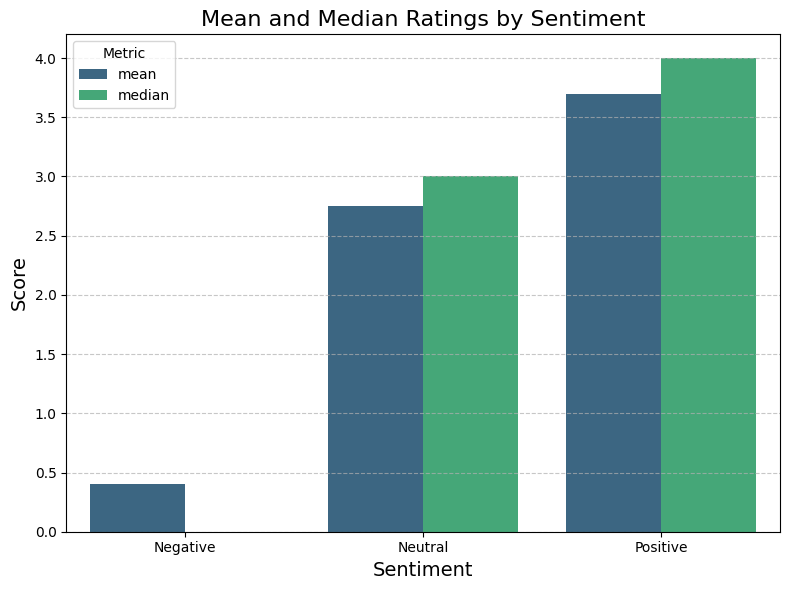

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the stats DataFrame for easier plotting
stats_melted = grouped_data.melt(id_vars="sentiment_result", value_vars=["mean", "median"], var_name="Metric", value_name="Score")

# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(x="sentiment_result", y="Score", hue="Metric", data=stats_melted, palette="viridis")

# Customize the plot
plt.title("Mean and Median Ratings by Sentiment", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


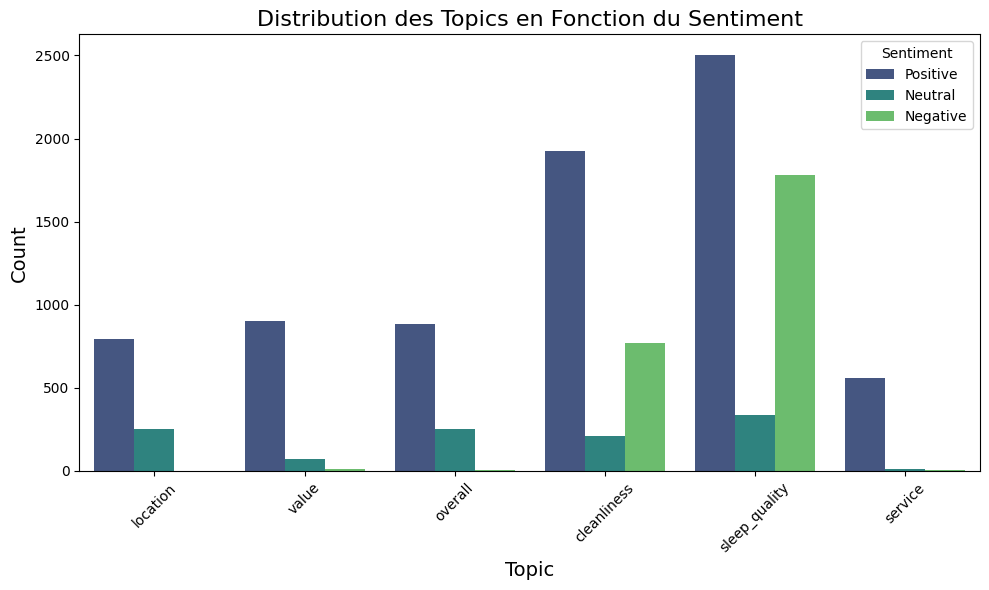

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

topics = {
    1: 'service',
    2: 'cleanliness',
    3: 'overall',
    4: 'value',
    5: 'location',
    6: 'sleep_quality',
    7: 'rooms'
}

data['assigned_topic'] = data['assigned_topic'].map(topics)

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='assigned_topic', hue='sentiment_result', palette='viridis')

plt.title('Distribution des Topics en Fonction du Sentiment', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', loc='upper right')

plt.tight_layout()
plt.show()
